In [1]:
import tensorflow as tf
#import Homogeneous_Poisson_NN
from Homogeneous_Poisson_NN import Homogeneous_Poisson_NN_2#,Homogeneous_Poisson_NN
from generate_cholesky_soln import generate_dataset
from generate_analytical_soln import generate_analytical_solution_homogeneous_bc
import numpy as np
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float32')

In [2]:
mod = Homogeneous_Poisson_NN_2(data_format = 'channels_first', mse_component_weight = 1e+1)
mod((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())))
from IPython.display import clear_output
clear_output()
#mod.load_weights('Homogeneous_Poisson_NN_3.h5')

In [3]:
def dataset_generator_2(n_batches = 60, dx = 0.1*(np.random.rand() + 0.01), nx = 64, ny = 64):
    
#     nx = np.random.randint(64,128)
#     ny = np.random.randint(64,128)
#     if np.random.rand() > 0.5:
#         nx = 64
#     else:
#         nx = 64
        
#     if np.random.rand() > 0.5:
#         ny = 64
#     else:
#         ny = 64
    batch_size = 125
    while True:
        dx = 0.1*(np.random.rand() + 0.01)
        if np.random.rand() < -1:
            soln, rhs = generate_analytical_solution_homogeneous_bc(output_shape=(ny,nx), nmodes=(32,32), max_random_magnitude=1.0, domain = [(nx-1)*dx, (ny-1)*dx], n_random=batch_size, expanded_dims = True)
            yield ((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln)
        else:
            soln, rhs = generate_dataset(batch_size, [nx,ny], dx, {'top':np.zeros(nx),'bottom':np.zeros(nx),'left':np.zeros(ny),'right':np.zeros(ny)})
            yield ((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln)
def dataset_generator_2_rbg():
    batch_size = 35
    while True:
        nx = np.random.randint(64,128)
        ny = np.random.randint(64,128)
#         if np.random.rand() > 0.5:
#             nx = 64
#         else:
#             nx = 64

#         if np.random.rand() > 0.5:
#             ny = 64
#         else:
#             ny = 64
        dx = 0.05#0.1*(np.random.rand() + 0.01)
        if np.random.rand() < -1:
            soln, rhs = generate_analytical_solution_homogeneous_bc(output_shape=(ny,nx), nmodes=(32,32), max_random_magnitude=1.0, domain = [(nx-1)*dx, (ny-1)*dx], n_random=batch_size, expanded_dims = True)
            yield ((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln)
        else:
            soln, rhs = generate_dataset(batch_size, [nx,ny], dx, {'top':np.zeros(nx),'bottom':np.zeros(nx),'left':np.zeros(ny),'right':np.zeros(ny)})
            yield ((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln)

'''
NOTES:
-Mixing 'analytical dataset' and Cholesky seems to result in not-so-good behaviour
-Learning rate should be super small

---these parameters led to decent results on the variable dx 64x64 case: (results saved in Homogeneous_Poisson_NN_2.h5)
dataset:
batch size 125, Fourier data excluded
training:
cb = [tf.keras.callbacks.ModelCheckpoint('Homogeneous_Poisson_NN_2.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr = 1e-15)]
mod.compile(loss = mod.integral_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), metrics = ['mse', 'mae'])
mod.run_eagerly = True
mod.fit_generator(generator=dataset_generator_2(), steps_per_epoch=600, epochs=5000, validation_data=dataset_generator_2(), validation_steps=3, callbacks=cb)

When trained on ONLY interpolation dataset, the results for the analytical one are max 10% off pointwise!
'''

"\nNOTES:\n-Mixing 'analytical dataset' and Cholesky seems to result in not-so-good behaviour\n-Learning rate should be super small\n\n---these parameters led to decent results on the variable dx 64x64 case: (results saved in Homogeneous_Poisson_NN_2.h5)\ndataset:\nbatch size 125, Fourier data excluded\ntraining:\ncb = [tf.keras.callbacks.ModelCheckpoint('Homogeneous_Poisson_NN_2.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr = 1e-15)]\nmod.compile(loss = mod.integral_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), metrics = ['mse', 'mae'])\nmod.run_eagerly = True\nmod.fit_generator(generator=dataset_generator_2(), steps_per_epoch=600, epochs=5000, validation_data=dataset_generator_2(), validation_steps=3, callbacks=cb)\n\nWhen trained on ONLY interpolation dataset, the results for the analytical one are max 10% off pointwise!\n"

In [4]:
cb = [tf.keras.callbacks.ModelCheckpoint('Homogeneous_Poisson_NN_variablex.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr = 1e-15, verbose = True, patience = 3)]
mod.compile(loss = mod.integral_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), metrics = ['mse', 'mae'])
mod.run_eagerly = True
mod.fit_generator(generator=dataset_generator_2_rbg(), steps_per_epoch=200, epochs=5000, validation_data=dataset_generator_2_rbg(), validation_steps=3, callbacks=cb)
#maybe incorporate delta x and domain size information? via [dx, dy, Lx, Ly] -> dense layers -> einsum into conv filters

Epoch 1/5000
199/200 [============================>.] - ETA: 2s - loss: 0.5237 - mse: 0.0197 - mae: 0.0921
Epoch 00001: loss improved from inf to 0.52213, saving model to Homogeneous_Poisson_NN_variablex.h5
200/200 [==============================] - 488s 2s/step - loss: 0.5221 - mse: 0.0197 - mae: 0.0919 - val_loss: 0.5005 - val_mse: 0.0070 - val_mae: 0.0627
Epoch 2/5000
199/200 [============================>.] - ETA: 2s - loss: 0.2698 - mse: 0.0036 - mae: 0.0412
Epoch 00002: loss improved from 0.52213 to 0.26963, saving model to Homogeneous_Poisson_NN_variablex.h5
200/200 [==============================] - 472s 2s/step - loss: 0.2696 - mse: 0.0036 - mae: 0.0411 - val_loss: 0.2489 - val_mse: 0.0029 - val_mae: 0.0348
Epoch 3/5000
199/200 [============================>.] - ETA: 2s - loss: 0.1978 - mse: 0.0021 - mae: 0.0313
Epoch 00003: loss improved from 0.26963 to 0.19717, saving model to Homogeneous_Poisson_NN_variablex.h5
200/200 [==============================] - 465s 2s/step - loss:

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast] name: Cast/

In [38]:
mod.save_weights('Homogeneous_Poisson_NN.h5')

In [44]:
dx = 0.1*(np.random.rand() + 0.01)#0.04016651#0.05#
nx = 64#np.random.randint(64,128)
ny = 64#np.random.randint(64,128)
batch_size = 100
soln, rhs = generate_analytical_solution_homogeneous_bc(output_shape=(ny,nx), nmodes=(32,32), max_random_magnitude=1.0, domain = [(nx-1)*dx, (ny-1)*dx], n_random=batch_size, expanded_dims= True)


In [12]:
dx

0.034681940925285794

(64, 64)
(64, 64)


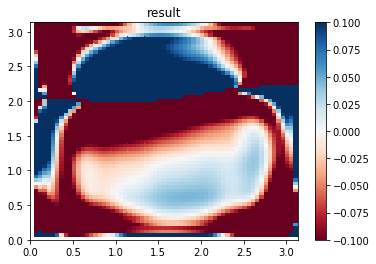

In [52]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*dx, soln.shape[-2]), np.linspace(0, soln.shape[-1]*dx, soln.shape[-1]), indexing = 'ij')
#p_r = np.random.randint(0,soln.shape[0])
z = soln[p_r,0,...]
#z = rhs[p_r,...]
print(z.shape)
print(x.shape)
z = mod((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())))[p_r,0,...]
#z = mod((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())))[p_r,0,...] - soln[p_r,0,...]
z = tf.divide(mod((rhs, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())))[p_r,0,...] - soln[p_r,0,...], soln[p_r,0,...])
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('result')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
from conv_laplacian_loss import conv_laplacian_loss
cll = conv_laplacian_loss((ny,nx), dx)
#cll(tf.expand_dims(rhs, axis = 1), tf.expand_dims(soln, axis = 1))
cll(rhs,soln)

In [100]:
mod.compile(loss = lf, optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5))

In [22]:
dx

0.008789778496342436

In [14]:
rhs.shape

TensorShape([100, 1, 128, 64])

In [ ]:
from importlib import reload
reload(Homogeneous_Poisson_NN)
mod = Homogeneous_Poisson_NN.Homogeneous_Poisson_NN_2(data_format = 'channels_first', Lp_norm_power=2)
nx1 = 100
nx2 = 100
dx = 0.01
Lx1 = 1.0
Lx2 = 1.0
batch_size = 1
mod((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), dx*tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())))
from IPython.display import clear_output
clear_output()
x = np.array(np.meshgrid(np.linspace(0, Lx1, nx1),np.linspace(0, Lx2, nx2),indexing = 'xy'), dtype = np.float64).transpose((1,2,0))
y = np.sin(x[:,:,0] - x[:,:,1])
mod.integral_loss_2(y, tf.zeros((batch_size,1,nx1,nx2), dtype = tf.float64)) #ttf.ones((batch_size,1,nx1,nx2), dtype = tf.float64)

(100, 100)

In [8]:
i = dataset_generator_2()
s = next(i)
from conv_laplacian_loss import conv_laplacian_loss
cll = conv_laplacian_loss((64,64), s[0][1][0,0])
cll(s[0][0], s[1])

<tf.Tensor: id=102308, shape=(), dtype=float64, numpy=5.063595015141838e-07>